In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import config as cfg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from utils import build_trip_count, build_distance_count, get_district_names, normalize_by_pop, get_income_data, add_quantiles

In [18]:
# DEFINING LABELS OF NODES 
district_mapping = pd.read_csv('/Users/caro/Desktop/thesis_project/data_overview/outputs/districts_and_population.csv')
id_to_name = district_mapping.set_index('ID')['name_2'].to_dict()


# TRIP ANALYSIS --------------------------------------------------------------------------------------------------- 

def build_trip_count(df): # FIXED
    # Determine the grouping columns based on whether sociodemographic_var is provided
    grouping_columns = ['origen', 'destino']

    # Group by the determined columns and sum the 'viajes' column
    trip_counts = df.groupby(grouping_columns)['viajes'].sum().reset_index(name='trip_count')
    return trip_counts

def build_distance_count(df): # FIXED, AND NEW
    '''I am obtaining the km per trip! REVIEW'''
    # Group by 'origen' and 'destino' and calculate the sum of 'viajes_km' and 'viajes'
    trip_counts = df.groupby(['origen', 'destino']).agg({
        'viajes_km': 'sum',
        'viajes': 'sum'
    }).reset_index()
    
    # Calculate the ratio and add it as a new column
    trip_counts['distance_per_trip'] = trip_counts['viajes_km'] / trip_counts['viajes']
    
    return trip_counts

def get_district_names(trip_counts):
    # get names of districts
    trip_counts = trip_counts.merge(district_mapping[['ID', 'name_2']], how='left', left_on='origen', right_on='ID')
    trip_counts = trip_counts.rename(columns={'name_2': 'origin'})
    trip_counts = trip_counts.merge(district_mapping[['ID', 'name_2']], how='left', left_on='destino', right_on='ID')
    trip_counts = trip_counts.rename(columns={'name_2': 'destination'})

    # drop extra columns
    trip_counts = trip_counts.drop(columns=['ID_x', 'ID_y'])

    return trip_counts

def normalize_by_pop(trip_counts, population_df):
    trip_counts = trip_counts.merge(population_df, left_on='origen', right_on='ID', how='left')
    # Normalize trip counts by population of the origin district
    trip_counts['normalized_trip_count'] = trip_counts['trip_count'] / trip_counts['Population']
    trip_counts.drop(columns=['ID','Population'], inplace=True)  # removing extra columns
    return trip_counts


def get_income_data(trip_counts, income, income_var_1, income_var_2):
    # get origin incomes
    trip_counts = trip_counts.merge(
    income[['ID', income_var_1, income_var_2]], 
    left_on='origen', 
    right_on='ID', 
    how='left'
)
    # rename
    trip_counts.rename(columns={income_var_1: f'Origin {income_var_1}'}, inplace=True)
    trip_counts.rename(columns={income_var_2: f'Origin {income_var_2}'}, inplace=True)

    # drop extra columns
    trip_counts.drop(columns=['ID'], inplace=True)

    # get destination incomes
    trip_counts = trip_counts.merge(
        income[['ID', income_var_1, income_var_2]], 
        left_on='destino', 
        right_on='ID', 
        how='left'
    )

    # rename columns
    trip_counts.rename(columns={income_var_1: f'Destination {income_var_1}'}, inplace=True)
    trip_counts.rename(columns={income_var_2: f'Destination {income_var_2}'}, inplace=True)
    # drop extra columns
    trip_counts.drop(columns=['ID', 'origen', 'destino'], inplace=True)

    return trip_counts

def add_quantiles(trip_counts, income_var, n_quantiles=6):
    trip_counts[f'income decile origin {income_var}'] = pd.qcut(trip_counts[f'Origin {income_var}'], n_quantiles, labels=False, duplicates='drop')
    trip_counts[f'income decile destination {income_var}'] = pd.qcut(trip_counts[f'Destination {income_var}'], n_quantiles, labels=False, duplicates='drop') 
    return trip_counts

In [19]:
if cfg.type_of_study == 'month':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'all_viajes_month_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during March 2022
    data_name = 'March 2022'
elif cfg.type_of_study == 'week':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'viajes_week_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during a 'normal' week
    data_name = 'Normal Week'
elif cfg.type_of_study == 'two_weeks':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'viajes_two_weeks_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during 2 weeks
    data_name = 'Two Weeks'
elif cfg.type_of_study == 'weekend':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'viajes_weekend_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during 2 weeks
    data_name = 'Weekend'
else:
    raise ValueError('No time of study has been set')

In [20]:
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson') # income data
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson') # geodataframe
gdf = gdf.to_crs(epsg=4326) # setting crs
district_mapping = pd.read_csv('/Users/caro/Desktop/thesis_project/data_overview/outputs/districts_and_population.csv')

In [21]:
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')] # home origin trips

In [22]:
# Group by 'origen' and sum 'viajes'
district_counts = filtered_df.groupby('origen')['viajes'].sum().reset_index(name='total_viajes') # FIXED
district_counts.columns = ['ID', 'Population']

In [23]:
district_counts

,ID,Population
0,2807901,136712522521830
1,2807902,168422569542303
2,2807903,140204703470897
3,2807904,137807602115964
4,2807905,155758333501603
5,2807906,139590562531537
6,2807907,122276371681272
7,2807908,172106172640282
8,2807909,159416530936269
9,2807910,152988112059524


In [24]:
trip_counts = build_trip_count(filtered_df)
trip_counts = get_district_names(trip_counts)
#trip_counts = normalize_by_pop(trip_counts, district_counts)

In [25]:
trip_counts

,origen,destino,trip_count,origin,destination
0,2807901,2807901,24324971550694,Centro,Centro
1,2807901,2807902,18484663675589,Centro,Arganzuela
2,2807901,2807903,9149580288556,Centro,Retiro
3,2807901,2807904,5956602526113,Centro,Salamanca
4,2807901,2807905,2407389146007,Centro,Chamartín
...,...,...,...,...,...
436,2807921,2807917,3455182,Barajas,Villaverde
437,2807921,2807918,6276638,Barajas,Villa de Vallecas
438,2807921,2807919,124321622892,Barajas,Vicálvaro
439,2807921,2807920,20348620894106,Barajas,San Blas-Canillejas


/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_38973/2980835591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['fecha'] = pd.to_datetime(filtered_df['fecha'], format='%Y%m%d')  # Ensure 'fecha' is a datetime type


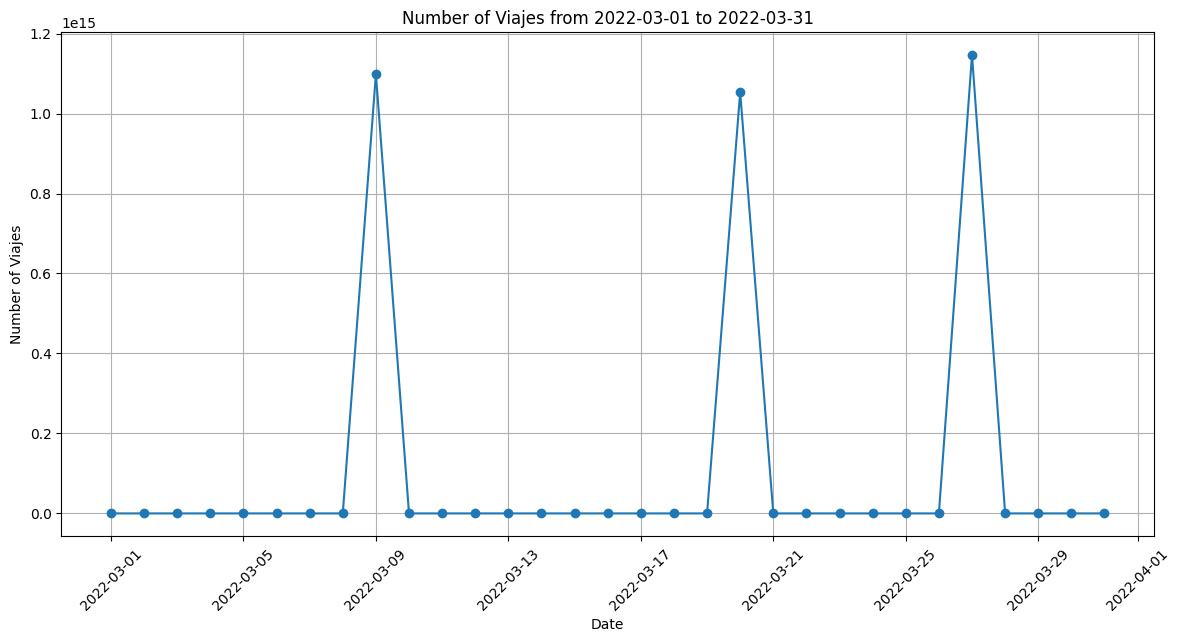

In [31]:
import matplotlib.pyplot as plt

# Filter the dataframe for the date range
filtered_df['fecha'] = pd.to_datetime(filtered_df['fecha'], format='%Y%m%d')  # Ensure 'fecha' is a datetime type
filtered_range = filtered_df.loc[(filtered_df['fecha'] >= '2022-03-01') & (filtered_df['fecha'] <= '2022-03-31')]

# Group by 'fecha' and sum the 'viajes' column
viajes_per_day = filtered_range.groupby('fecha')['viajes'].sum().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(viajes_per_day['fecha'], viajes_per_day['viajes'], marker='o')
plt.title('Number of Viajes from 2022-03-01 to 2022-03-31')
plt.xlabel('Date')
plt.ylabel('Number of Viajes')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [33]:
viajes_per_day

,fecha,viajes
0,2022-03-01,2582552942
1,2022-03-02,2651758698
2,2022-03-03,2533559769
3,2022-03-04,2602455543
4,2022-03-05,2184174617
5,2022-03-06,1928414793
6,2022-03-07,2487627995
7,2022-03-08,2617556068
8,2022-03-09,1098688609083547
9,2022-03-10,2503771153


Top Origin-Destination pairs for anomalous days:
      origen  destino          viajes
88   2807905  2807905  14417109304165
374  2807918  2807918  14185935351819
219  2807911  2807910  13221793374454
396  2807919  2807919  13096044700450
330  2807916  2807916  12950205177144
220  2807911  2807911  12486694286749
254  2807913  2807903  12418799213942
44   2807903  2807903  12280824624969
199  2807910  2807911  11640253724105
369  2807918  2807913  11586595852295


/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_38973/4072099657.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_anomalous = filtered_df.loc[filtered_df['fecha'].isin(anomalous_days)]


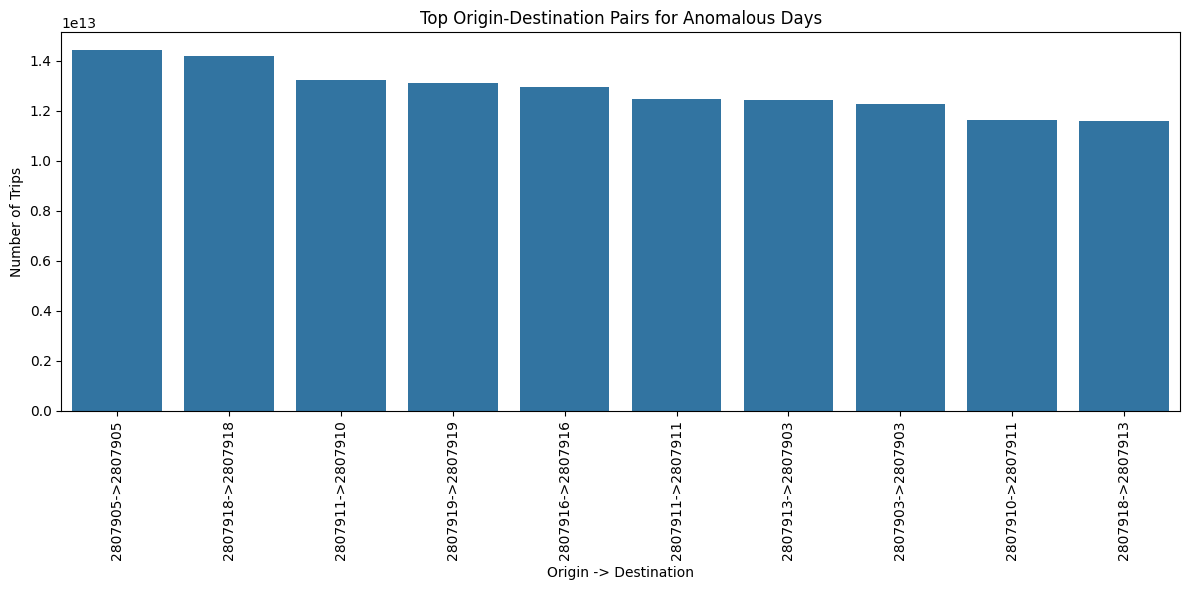

In [37]:
# Filter for anomalous days
anomalous_days = ['2022-03-09']
filtered_anomalous = filtered_df.loc[filtered_df['fecha'].isin(anomalous_days)]

# Group by origin and destination and sum the trips
anomalous_trips = filtered_anomalous.groupby(['origen', 'destino'])['viajes'].sum().reset_index()

# Sort by trip count in descending order
anomalous_trips_sorted = anomalous_trips.sort_values(by='viajes', ascending=False)

# Display the top contributors to the anomaly
print("Top Origin-Destination pairs for anomalous days:")
print(anomalous_trips_sorted.head(10))

# Plot the anomalous origin-destination pairs
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    x=anomalous_trips_sorted.head(10)['origen'].astype(str) + '->' + anomalous_trips_sorted.head(10)['destino'].astype(str),
    y=anomalous_trips_sorted.head(10)['viajes']
)
plt.xticks(rotation=90)
plt.title('Top Origin-Destination Pairs for Anomalous Days')
plt.xlabel('Origin -> Destination')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()


Top Origin-Destination pairs for anomalous days:
      origen  destino          viajes
418  2807920  2807920  17700042704726
352  2807917  2807917  15092244683756
154  2807908  2807908  14960684751167
221  2807911  2807912  14411504253777
374  2807918  2807918  13737206562739
269  2807913  2807918  13001364697107
254  2807913  2807903  12602925892843
162  2807908  2807916  12299760700559
330  2807916  2807916  12184195454417
335  2807916  2807921  11843743880937


/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_38973/747896904.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_anomalous = filtered_df.loc[filtered_df['fecha'].isin(anomalous_days)]


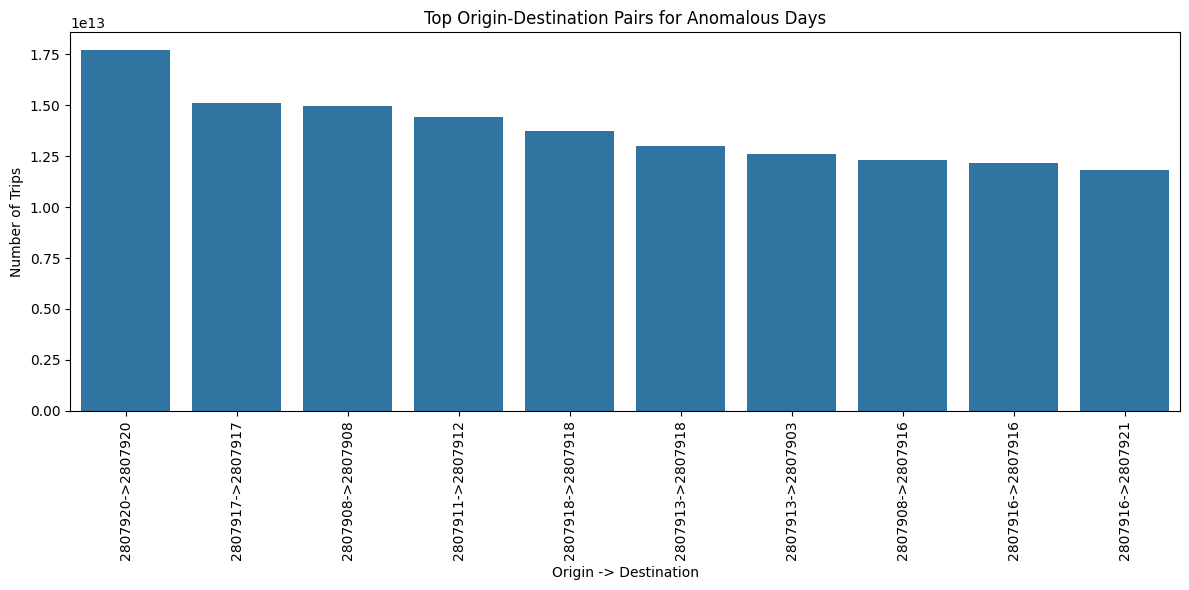

In [39]:
# Filter for anomalous days
anomalous_days = ['2022-03-20']
filtered_anomalous = filtered_df.loc[filtered_df['fecha'].isin(anomalous_days)]

# Group by origin and destination and sum the trips
anomalous_trips = filtered_anomalous.groupby(['origen', 'destino'])['viajes'].sum().reset_index()

# Sort by trip count in descending order
anomalous_trips_sorted = anomalous_trips.sort_values(by='viajes', ascending=False)

# Display the top contributors to the anomaly
print("Top Origin-Destination pairs for anomalous days:")
print(anomalous_trips_sorted.head(10))

# Plot the anomalous origin-destination pairs
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    x=anomalous_trips_sorted.head(10)['origen'].astype(str) + '->' + anomalous_trips_sorted.head(10)['destino'].astype(str),
    y=anomalous_trips_sorted.head(10)['viajes']
)
plt.xticks(rotation=90)
plt.title('Top Origin-Destination Pairs for Anomalous Days')
plt.xlabel('Origin -> Destination')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

Top Origin-Destination pairs for anomalous days:
      origen  destino          viajes
330  2807916  2807916  17707838373578
352  2807917  2807917  16652345067213
418  2807920  2807920  16602967748324
198  2807910  2807910  15436764435162
264  2807913  2807913  15243449152311
154  2807908  2807908  15087041708754
221  2807911  2807912  14970099907996
220  2807911  2807911  13814652636660
219  2807911  2807910  12671179858103
199  2807910  2807911  11012223043777


/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_38973/4087027096.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_anomalous = filtered_df.loc[filtered_df['fecha'].isin(anomalous_days)]


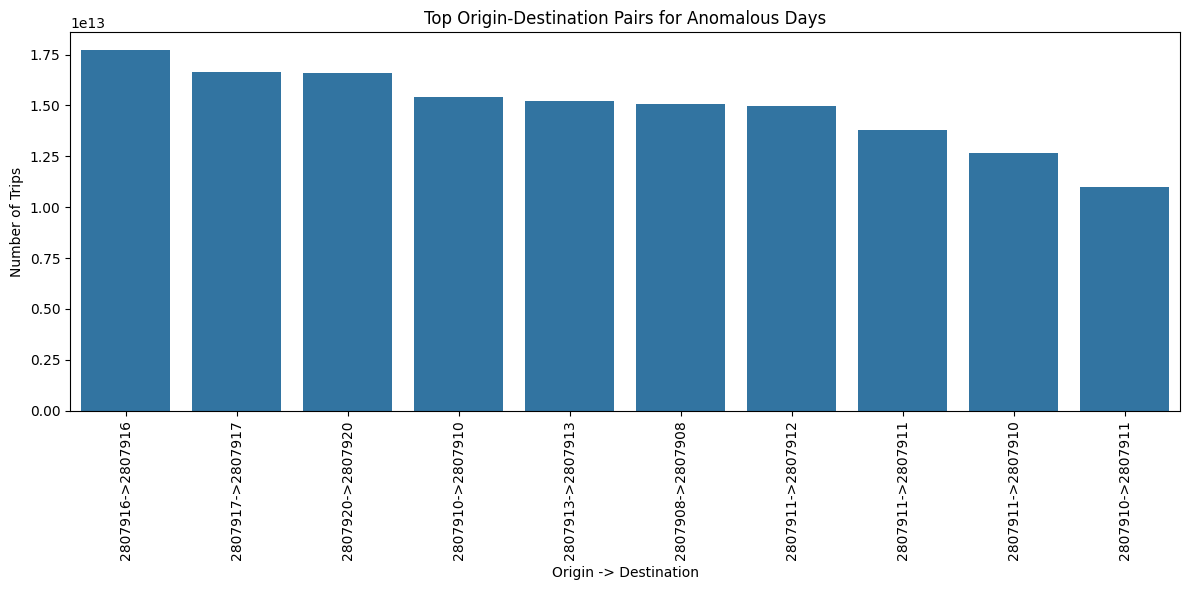

In [40]:
# Filter for anomalous days
anomalous_days = ['2022-03-27']
filtered_anomalous = filtered_df.loc[filtered_df['fecha'].isin(anomalous_days)]

# Group by origin and destination and sum the trips
anomalous_trips = filtered_anomalous.groupby(['origen', 'destino'])['viajes'].sum().reset_index()

# Sort by trip count in descending order
anomalous_trips_sorted = anomalous_trips.sort_values(by='viajes', ascending=False)

# Display the top contributors to the anomaly
print("Top Origin-Destination pairs for anomalous days:")
print(anomalous_trips_sorted.head(10))

# Plot the anomalous origin-destination pairs
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    x=anomalous_trips_sorted.head(10)['origen'].astype(str) + '->' + anomalous_trips_sorted.head(10)['destino'].astype(str),
    y=anomalous_trips_sorted.head(10)['viajes']
)
plt.xticks(rotation=90)
plt.title('Top Origin-Destination Pairs for Anomalous Days')
plt.xlabel('Origin -> Destination')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

In [38]:
normal_days = filtered_df.loc[~filtered_df['fecha'].isin(anomalous_days)]
normal_trips = normal_days.groupby(['origen', 'destino'])['viajes'].sum().reset_index()
normal_trips_sorted = normal_trips.sort_values(by='viajes', ascending=False)

# Compare anomalous and normal days side by side
comparison = anomalous_trips_sorted.merge(normal_trips_sorted, on=['origen', 'destino'], suffixes=('_anomalous', '_normal'))
print(comparison.head(10))

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_38973/2990032077.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  normal_days = filtered_df.loc[~filtered_df['fecha'].isin(anomalous_days)]


    origen  destino  viajes_anomalous   viajes_normal
0  2807905  2807905    14417109304165  17233116773566
1  2807918  2807918    14185935351819  24452784493914
2  2807911  2807910    13221793374454  23447203662491
3  2807919  2807919    13096044700450  20334564290254
4  2807916  2807916    12950205177144  29894273706944
5  2807911  2807911    12486694286749  24255547780694
6  2807913  2807903    12418799213942  22293524883636
7  2807903  2807903    12280824624969  18634156061167
8  2807910  2807911    11640253724105  19057671385399
9  2807918  2807913    11586595852295  19545971446211


In [41]:
# Calculate the total number of trips for each origin
total_trips_by_origin = filtered_df.groupby('origen')['viajes'].sum().reset_index()
total_trips_by_origin.rename(columns={'viajes': 'total_viajes'}, inplace=True)

# Merge the total trips back into the original DataFrame
normalized_df = pd.merge(filtered_df, total_trips_by_origin, on='origen')

# Calculate the normalized trip count
normalized_df['normalized_viajes'] = normalized_df['viajes'] / normalized_df['total_viajes']

# Group by origin-destination to see the distribution
normalized_distribution = normalized_df.groupby(['origen', 'destino'])['normalized_viajes'].sum().reset_index()

# Sort by normalized trips for better understanding
normalized_distribution_sorted = normalized_distribution.sort_values(by='normalized_viajes', ascending=False)


      origen  destino  normalized_viajes
440  2807921  2807921           0.397649
352  2807917  2807917           0.333241
396  2807919  2807919           0.280545
374  2807918  2807918           0.263424
435  2807921  2807916           0.263014
439  2807921  2807920           0.259738
330  2807916  2807916           0.249675
418  2807920  2807920           0.241978
154  2807908  2807908           0.238309
198  2807910  2807910           0.231872


In [42]:
normalized_distribution_sorted

,origen,destino,normalized_viajes
440,2807921,2807921,3.976489e-01
352,2807917,2807917,3.332409e-01
396,2807919,2807919,2.805448e-01
374,2807918,2807918,2.634238e-01
435,2807921,2807916,2.630138e-01
...,...,...,...
144,2807907,2807919,6.115271e-08
139,2807907,2807914,5.769946e-08
430,2807921,2807911,5.604007e-08
436,2807921,2807917,4.410337e-08
